# CODE

## Module Imports

In [1]:
import collections
import json
import math
import random

import networkx as nx
import numpy as np
import pandas as pd

In [2]:
# MATPLOTLIB AND SEABORN
import matplotlib.pylab as pylab
from matplotlib.patches import Rectangle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

%matplotlib inline
# %matplotlib notebook

pylab.rcParams['font.size'] = 24
pylab.rcParams['figure.figsize'] = [3*x for x in [3.52, 2.64]]
pylab.rcParams['figure.dpi'] = 100
pylab.rcParams['errorbar.capsize'] = 3
pylab.rcParams['legend.fontsize'] = 12
pylab.rcParams['lines.linewidth'] = 2

gridcolor = '#bbbbbb'

zvalue = 2.576  # 99%

## Helper Functions

### Info

In [3]:

def Info(net_json, net_graph, demands_json):
    total_pktrate = 0
    for d in demands_json['demands_list']:
        total_pktrate = total_pktrate + d['pktrate']
    return {
        'nodes': net_json['n_nodes'],
        'links': net_json['n_edges'],
        'total_pktrate': total_pktrate,
#         'diamater': nx.diameter(net_graph),
        'avg_path_length': nx.average_shortest_path_length(net_graph)
    }


### Mirroring

In [4]:

def Mirroring(net_json, net_graph, demands_json):
    # report rate
    pr = 0
    for d in demands_json['demands_list']:
        pr = pr + (d['pktrate']*nx.shortest_path_length(net_graph, d['src'], d['dst']))
    #
    return {
        'report_rate': pr,
        'sram_memory': 0,
        'tcam_memory': 0,
        'header_space': 0,
    }


### TPP

In [5]:

def TPP(net_json, net_graph, demands_json):
    # report rate, maximum and average header space
    rr = 0
    hs = np.zeros(len(demands_json['demands_list']))
    for i, d in enumerate(demands_json['demands_list']):
        rr = rr + d['pktrate']
        hs[i] = 9 + 8*nx.shortest_path_length(net_graph, d['src'], d['dst'])
        
    return {
        'report_rate': rr,
        'sram_memory': 0,
        'tcam_memory': 0,
        'header_space_max': hs.max(),
        'header_space_min': hs.min(),
        'header_space_avg': hs.mean(),
        'header_space_med': np.median(hs),
        'header_space_std': hs.std(),
        'header_space_err': (zvalue*hs.std())/math.sqrt(len(hs)),
    }


### SwitchPointer

In [6]:

def SwitchPointer(net_json, net_graph, demands_json, eps=100, mfr=1000):
    # eps: epochs per second
    fpp = 512  # flows per ordered pair <source, destination>
    fps = (net_json['n_nodes'] - 1)*fpp  # flows per source
    # report rate, maximum and average header space
    rr = 0
    hs = np.zeros(len(demands_json['demands_list']))
    for i, d in enumerate(demands_json['demands_list']):
        active_flows = min(fpp, math.ceil(d['pktrate']/mfr))
        rr = rr + min(d['pktrate'], active_flows*eps)
        hs[i] = 17 + 8*nx.shortest_path_length(net_graph, d['src'], d['dst'])
    
    # TABLE MEMORY
    # FlowID
    flowid_tcam = 2*fps*int(math.ceil(math.log2(net_json['n_nodes'] + 1)))  # extend IPvX FIB with egress/dst node
    flowid_sram = 2*fps*(2*int(math.ceil(math.log2(net_json['n_nodes'] + 1))) + 8 + 2*16 + int(math.ceil(math.log2(2*fps - 1))))
    
    # REGISTER MEMORY
    ## REGISTER MEMORY
    # NodeID
    rm = int(math.ceil(math.log2(net_json['n_nodes'])))
    ### Ingress Node
    # Epoch
    rm = rm + 16*fps
    # RxBits, RxPkts
    rm = rm + (32*2)*fps
    ### Egress Node
    # Epoch
    rm = rm + 16*fps
    # TxBits, TxPkts
    rm = rm + (32*2)*fps
    # Telemetry Fields in Packets (Includes RxBits and RxPkts)
    rm = rm + hs.max()*8*fps
    ## POINTER MEMORY
    pm = (1e3/eps)*net_json['n_nodes']*3
    
    return {
        'report_rate': rr,
        'flowid_tcam': flowid_tcam,
        'tcam_all': flowid_tcam,
        'flowid_sram': flowid_sram,
        'pointer_memory': pm,
        'register_memory': rm,
        'sram_all': rm + flowid_sram + pm,
        'header_space_max': hs.max(),
        'header_space_min': hs.min(),
        'header_space_avg': hs.mean(),
        'header_space_med': np.median(hs),
        'header_space_std': hs.std(),
        'header_space_err': (zvalue*hs.std())/math.sqrt(len(hs)),
    }


### IntSight

#### PathID-related Helper Functions

In [7]:
Rule = collections.namedtuple('Rule', ['source', 'path_len', 'next_node',
                                        'current_code', 'increment',
                                        'new_code'])


def get_paths(graph, source):
    """Computes and returns a sorted list of paths from source according to 
    network routing 'policies'."""
    targets = [v for v in sorted(nx.nodes(graph)) if v != source]
    paths = list()
    for target in targets:
        # PICK ONLY ONE OF THE POLICIES BELOW
        # Policy: All Shortest Paths
        paths += list(nx.all_shortest_paths(graph, source, target))
        
        # # Policy: All Simple Paths
        # paths += list(nx.all_simple_paths(graph, source, target))

        # # Policy: All Simple Paths with Limited Length
        # spl = nx.shortest_path_length(graph, source, target)
        # allowed_stretch = 2 # hops
        # paths += list(nx.all_simple_paths(graph, source, target,
        #                                   cutoff=spl + allowed_stretch))
    
    return sorted(paths)


def encode(graph, verbose=False):
    """Generates a unique code for each path in the network with same tuple 
    (source, destination, length)."""
    sources = list(nx.nodes(graph))

    rules = list()
    for _ in range(len(sources)):
        rules.append(list())
        
    path_ID_decoder = {}
    for source in sources:
        paths = get_paths(graph, source)
        prev_path = []

        next_code = list()
        for _ in range(len(sources)):
            next_code.append([0]*len(sources))

        for path in paths:
            if verbose:
                print('path:', path)
            parent_node = None
            level = 0
            node = path[level]
            while level < len(prev_path) and prev_path[level] == node:
                # Same subpath, move along
                parent_node = node
                level = level + 1
                node = path[level]
            
            while level < len(path):
                node = path[level]
                if verbose:
                    print('node', node)
                    print('parent_node:', parent_node)
                # Get code for parent at previous level
                parent_code = 0
                if level > 0:
                    parent_code = next_code[parent_node][level - 1] - 1
                if verbose:
                    print('parent_code:', parent_code)
                # Decide code for node at current level
                node_code = max(parent_code, next_code[node][level])
                if verbose:
                    print('node_code:', node_code)
                # Update code
                next_code[node][level] = node_code + 1
                # If parent and child codes are different, create a rule
                if node_code != parent_code:
                    rules[parent_node].append(Rule(
                        source=source,
                        path_len=level - 1,
                        next_node=node,
                        current_code=parent_code,
                        increment=node_code - parent_code,
                        new_code=node_code,
                    ))
                    if verbose:
                        print('create rule!')
                # Go to next level
                parent_node = node
                level = level + 1
            
#             path_ID = PathID(path[0], path[-1], len(path), node_code)
            path_ID = '{},{},{},{}'.format(path[0], path[-1], len(path), node_code)
            if path_ID in path_ID_decoder:
                raise Exception('Same ID for different paths.')
            
            path_ID_decoder[path_ID] = path
            prev_path = path
    
    for node in range(len(sources)):
        rules[node] = sorted(rules[node])

    return rules, path_ID_decoder


def get_mrsd(graph):
    rules, _ = encode(graph)

    mrsd = 0
    for dev, dev_rules in enumerate(rules):
        mrsd = max(mrsd, len(dev_rules))

    return mrsd


#### Main IntSight

In [8]:

def IntSight(net_json, net_graph, demands_json, eps=100, mfr=1000):
    # eps: epochs per second
    fpp = 512  # flows per pair <source, destination>
    fps = (net_json['n_nodes'] - 1)*fpp  # flows per source
    
    # SINGLE 1-SECOND EVENT REPORT RATE
    fii = pd.Series()
    shortest_paths = nx.shortest_path(net_graph)
    for src, dstpath in shortest_paths.items():
        for dst, path in dstpath.items():
            if src != dst:
                for u in path:
                    if u not in fii.index:
                        fii.loc[u] = 0
                    active_flows = min(fpp, math.ceil(demands_json['demands_matrix'][src][dst]/mfr))
                    fii.loc[u] = fii.loc[u] + min(active_flows*eps, demands_json['demands_matrix'][src][dst])
                    
    
    # TABLE MEMORY
    # FlowID
    flowid_tcam = 2*fps*int(math.ceil(math.log2(net_json['n_nodes'] + 1)))  # extend IPvX FIB with egress/dst node
    flowid_sram = 2*fps*(2*int(math.ceil(math.log2(net_json['n_nodes'] + 1))) + 8 + 2*16 + int(math.ceil(math.log2(2*fps - 1))))
    
    # SLOs Thresholds
    slos_sram = fps*(int(math.ceil(math.log2(2*fps - 1))) + 4 + 32 + 32)  # first: flowID,  4: slos, 32: e2e delay, 32: bw
    # Contention Thresholds
    maxdeg = 0
    for u in net_graph.nodes:
        maxdeg = max(len(net_graph[u]), maxdeg)
    contention_sram = maxdeg*(int(math.ceil(math.log2(maxdeg - 1))) + 32 + 32)  # first: interfaceID, 32: queue depth, 32: queueing delay
    # Suspicion Thresholds
    suspicion_sram = maxdeg*(int(math.ceil(math.log2(maxdeg - 1))) + 32 + 32)  # first: interfaceID, 32: bitrate, 32: pktrate
    # PathID
    mrsd = get_mrsd(net_graph)
    d = nx.diameter(net_graph)
    p = 0
    for u in net_graph.nodes():
        for v in net_graph.nodes():
            if u != v:
                p = max(p, len(list(nx.all_shortest_paths(net_graph, u, v))))
    pathid_single = (2*int(math.ceil(math.log2(net_json['n_nodes'] + 1))) + int(math.ceil(math.log2(d + 1))) + 2*int(math.ceil(math.log2(p + 1))))
    pathid_ms = mrsd*pathid_single
    
    # REGISTER MEMORY
    # NodeID
    rm = int(math.ceil(math.log2(net_json['n_nodes'])))
    ## INGRESS NODE
    # Ingress Epoch
    rm = rm + 16*fps
    # RxPkts, RxBits
    rm = rm + (32*2)*fps
    ## EGRESS NODE
    # Ingress and Egress Epoch
    rm = rm + 2*16*fps
    # RxPkts, RxBits, HighDelays, TxPkts, TxBits
    rm = rm + (32*5)*fps
    # Path Src Field
    rm = rm + int(math.ceil(math.log2(net_json['n_nodes'] + 1)))*fps
    # Path Length
    rm = rm + int(math.ceil(math.log2(d + 1)))*fps
    # Path Code
    rm = rm + int(math.ceil(math.log2(p + 1)))*fps
    # Contention Points
    rm = rm + d*fps
    # Suspect
    rm = rm + d*fps
    
    # HEADER SPACE
    hs = 16  # epoch field
    hs = hs + int(math.ceil(math.log2(net_json['n_nodes'] + 1))) # path src field
    hs = hs + int(math.ceil(math.log2(d + 1))) # path length field
    hs = hs + int(math.ceil(math.log2(p + 1))) # path code field
    hs = hs + d  # contention points field
    hs = hs + d  # suspect field
    hs = hs + 3*32  # E2EDelay, RxPkts, RxBits
    hs = hs + 8  # NextHeader
    hs = int(math.ceil(hs/8))
    
    return {
        'report_rate_avg': fii.mean(),
        'report_rate_med': fii.median(),
        'report_rate_std': fii.std(),
        'report_rate_err': (zvalue*fii.std())/math.sqrt(len(fii)),
        'report_rate_min': fii.min(),
        'report_rate_max': fii.max(),
        
        'flowid_tcam': flowid_tcam,
        'tcam_all': flowid_tcam,
        
        'flowid_sram': flowid_sram,
        'slos_sram': slos_sram,
        'contention_sram': contention_sram,
        'suspicion_sram': suspicion_sram,
        'pathid_memory_sram': pathid_ms,
        'register_memory': rm,
        'sram_all': rm + slos_sram + flowid_sram + contention_sram + suspicion_sram + pathid_ms,
        
        'header_space': hs,
    }


## Main Code

In [9]:
def main(base_directory, datasets):    
    dfs = {}
    
    for ds in datasets:
        print('DATASET:', ds['name'])
        ds_directory = '{}/{}'.format(base_directory, ds['directory'])
        for net_name in ds['networks']:
            net_id = '{}/{}'.format(ds['name'], net_name)
            if net_id not in ['TopologyZoo/Bellcanada', 'TopologyZoo/UsSignal', 'TopologyZoo/VtlWavenet2011', 'TopologyZoo/TataNld', 'TopologyZoo/Cogentco', 'DEFO/rf1239_real_hard']: continue
            print('NETWORK: {}'.format(net_name), end=' ')
            net_json_fn = '{}/{}.graph.json'.format(ds_directory, net_name)
    
            with open(net_json_fn) as f:
                net_json = json.load(f)
    
            net_graph = nx.Graph()
            for node in net_json['nodes']:
                net_graph.add_node(node['id'], label=node['label'])

            for edge in net_json['edges']:
                net_graph.add_edge(edge['src'], edge['dst'], weight=1)
                net_graph.add_edge(edge['dst'], edge['src'], weight=1)
            
            demands_json_fn = '{}/{}{}.demands.json'.format(ds_directory, net_name, ds['demands'][0])
            with open(demands_json_fn) as f:
                demands_json = json.load(f)
            
            print(end='.')
            
            info = Info(net_json, net_graph, demands_json)
            if 'info' not in dfs:
                dfs['info'] = pd.DataFrame(columns=info.keys(), dtype=np.float64)
            dfs['info'].loc[net_id] = info
            
            print(end='.')
            
            mirroring = Mirroring(net_json, net_graph, demands_json)
            if 'mirroring' not in dfs:
                dfs['mirroring'] = pd.DataFrame(columns=mirroring.keys(), dtype=np.float64)
            dfs['mirroring'].loc[net_id] = mirroring
            
            print(end='.')
            
            tpp = TPP(net_json, net_graph, demands_json)
            if 'tpp' not in dfs:
                dfs['tpp'] = pd.DataFrame(columns=tpp.keys(), dtype=np.float64)
            dfs['tpp'].loc[net_id] = tpp
            
            print(end='.')
            
            switchpointer = SwitchPointer(net_json, net_graph, demands_json)
            if 'switchpointer' not in dfs:
                dfs['switchpointer'] = pd.DataFrame(columns=switchpointer.keys(), dtype=np.float64)
            dfs['switchpointer'].loc[net_id] = switchpointer
            
            print(end='.')
            
            intsight = IntSight(net_json, net_graph, demands_json)
            if 'intsight' not in dfs:
                dfs['intsight'] = pd.DataFrame(columns=intsight.keys(), dtype=np.float64)
            dfs['intsight'].loc[net_id] = intsight
            
            print(end='.')
            
            print('done')
            
    return dfs
            

In [10]:
%%time

datasets = [
    {"name": "TopologyZoo", "directory": "2016TopologyZooUCL_inverseCapacity", "demands": [".0000", ".0001", ".0002", ".0003", ".0004"], "networks": ["Aarnet", "Abilene", "Abvt", "Aconet", "Agis", "Ai3", "Airtel", "Amres", "Ans", "Arn", "Arnes", "Arpanet19706", "Arpanet19719", "Arpanet19723", "Arpanet19728", "Arpanet196912", "AsnetAm", "Atmnet", "AttMpls", "Azrena", "Bandcon", "Basnet", "Bbnplanet", "Bellcanada", "Bellsouth", "Belnet2003", "Belnet2004", "Belnet2005", "Belnet2006", "Belnet2007", "Belnet2008", "Belnet2009", "Belnet2010", "BeyondTheNetwork", "Bics", "Biznet", "Bren", "BsonetEurope", "BtAsiaPac", "BtEurope", "BtLatinAmerica", "BtNorthAmerica", "Canerie", "Carnet", "Cernet", "Cesnet1993", "Cesnet1997", "Cesnet1999", "Cesnet2001", "Cesnet200304", "Cesnet200511", "Cesnet200603", "Cesnet200706", "Cesnet201006", "Chinanet", "Claranet", "Cogentco", "Colt", "Columbus", "Compuserve", "CrlNetworkServices", "Cudi", "Cwix", "Cynet", "Darkstrand", "Dataxchange", "Deltacom", "DeutscheTelekom", "Dfn", "DialtelecomCz", "Digex", "Easynet", "Eenet", "EliBackbone", "Epoch", "Ernet", "Esnet", "Eunetworks", "Evolink", "Fatman", "Fccn", "Forthnet", "Funet", "Gambia", "Garr199901", "Garr199904", "Garr199905", "Garr200109", "Garr200112", "Garr200212", "Garr200404", "Garr200902", "Garr200908", "Garr200909", "Garr200912", "Garr201001", "Garr201003", "Garr201004", "Garr201005", "Garr201007", "Garr201008", "Garr201010", "Garr201012", "Garr201101", "Garr201102", "Garr201103", "Garr201104", "Garr201105", "Garr201107", "Garr201108", "Garr201109", "Garr201110", "Garr201111", "Garr201112", "Garr201201", "Gblnet", "Geant2001", "Geant2009", "Geant2010", "Geant2012", "Getnet", "Globalcenter", "Globenet", "Goodnet", "Grena", "Gridnet", "Grnet", "GtsCe", "GtsCzechRepublic", "GtsHungary", "GtsPoland", "GtsRomania", "GtsSlovakia", "Harnet", "Heanet", "HiberniaCanada", "HiberniaGlobal", "HiberniaIreland", "HiberniaNireland", "HiberniaUk", "HiberniaUs", "Highwinds", "HostwayInternational", "HurricaneElectric", "Ibm", "Iij", "Iinet", "Ilan", "Integra", "Intellifiber", "Internetmci", "Internode", "Interoute", "Intranetwork", "Ion", "IowaStatewideFiberMap", "Iris", "Istar", "Itnet", "Janetbackbone", "JanetExternal", "Janetlense", "Jgn2Plus", "Karen", "KentmanApr2007", "KentmanAug2005", "KentmanFeb2008", "KentmanJan2011", "KentmanJul2005", "Kreonet", "LambdaNet", "Latnet", "Layer42", "Litnet", "Marnet", "Marwan", "Missouri", "Mren", "Myren", "Napnet", "Navigata", "Netrail", "NetworkUsa", "Nextgen", "Niif", "Noel", "Nordu1989", "Nordu1997", "Nordu2005", "Nordu2010", "Nsfcnet", "Nsfnet", "Ntelos", "Ntt", "Oteglobe", "Oxford", "Pacificwave", "Packetexchange", "Padi", "Palmetto", "Peer1", "Pern", "PionierL1", "PionierL3", "Psinet", "Quest", "RedBestel", "Rediris", "Renam", "Renater1999", "Renater2001", "Renater2004", "Renater2006", "Renater2008", "Renater2010", "Restena", "Reuna", "Rhnet", "Rnp", "Roedunet", "RoedunetFibre", "Sago", "Sanet", "Sanren", "Savvis", "Shentel", "Sinet", "Singaren", "Spiralight", "Sprint", "Sunet", "Surfnet", "Switch", "SwitchL3", "Syringa", "TataNld", "Telcove", "Telecomserbia", "Tinet", "TLex", "Tw", "Twaren", "Ulaknet", "UniC", "Uninet", "Uninett2010", "Uninett2011", "Uran", "UsCarrier", "UsSignal", "Uunet", "Vinaren", "VisionNet", "VtlWavenet2008", "VtlWavenet2011", "WideJpn", "Xeex", "Xspedius", "York", "Zamren"]},
    {"name": "DEFO", "directory": "2015DEFO", "demands": [""], "networks": ["rf1221_real_hard", "rf1239_real_hard", "rf1755_real_hard", "rf3257_real_hard", "rf3967_real_hard", "rf6461_real_hard", "synth50_opt_hard", "synth100_opt_hard", "synth200_unary_hard"]}
]

dfs = main('./Repetita/data/', datasets)


DATASET: TopologyZoo
NETWORK: Bellcanada ......done
NETWORK: Cogentco ......done
NETWORK: TataNld ......done
NETWORK: UsSignal ......done
NETWORK: VtlWavenet2011 ......done
DATASET: DEFO
NETWORK: rf1239_real_hard ......done
CPU times: user 6min 13s, sys: 2.29 s, total: 6min 15s
Wall time: 6min 23s


## Plotting helper function and parameters

In [11]:

def plot_bars(dfs, networks, plots, xlabel, ylabel, stack=True, yscale=None, ylim=None, roundto=2):
    fig = pylab.figure()
    info = ''

    x = np.array(range(len(networks)))

    if stack is False:
        total_plots = 0
        for plot in plots:
            total_plots = total_plots + len(plot['ys'])
    else:
        total_plots = len(plots)
    barwidth = 1/(total_plots + 1.5)

    i = 0
    for plot in plots:
        lbls = plot['labels']
        ys = plot['ys']
        hatches = plot['hatches']
        if len(hatches) != len(ys):
            raise Error
        colors = plot['colors']
        if len(colors) != len(ys):
            raise Error
        yerrs = plot['yerrs'] if plot['yerrs'] is not None else [None]*len(ys)
        ymaxs = plot['ymaxs'] if plot['ymaxs'] is not None else [None]*len(ys)

        ybot = np.zeros(len(networks))

        for plabel, ylbl, yhatch, ycolor, yerrlbl, ymaxlbl in zip(lbls, ys, hatches, colors, yerrs, ymaxs):
            y = np.zeros(len(networks))
            if yerrlbl is not None:
                yerr = np.zeros(len(networks))
            else:
                yerr = None
            if ymaxlbl is not None:
                ymax = np.zeros(len(networks))
            else:
                ymax = None
            for j, net in enumerate(networks):
                y[j] = plot['yadjust'](dfs[plot['id']][ylbl].loc[net['id']], dfs, net['id'])
                if yerrlbl is not None:
                    yerr[j] = plot['yadjust'](dfs[plot['id']][yerrlbl].loc[net['id']], dfs, net['id'])
                if ymaxlbl is not None:
                    ymax[j] = plot['yadjust'](dfs[plot['id']][ymaxlbl].loc[net['id']], dfs, net['id'])
            pylab.bar(x=x + i*barwidth, height=y, yerr=yerr, bottom=ybot, width=barwidth, align='edge', edgecolor='k', capsize=5, label=plabel, hatch=yhatch, color=ycolor)
            if ymaxlbl is not None:
                pylab.scatter(x + i*barwidth + barwidth*0.5, ymax, marker='o', color=ycolor, edgecolor='k', s=50)
            if stack is True:
                ybot = ybot + y
            else:
                i = i + 1
            info += '# {}\ny: {}\n'.format(plabel, [round(a, roundto) for a in y])
            if yerrlbl is not None:
                info += 'yerr: {}\n'.format([round(a, roundto) for a in yerr])
            if ymaxlbl is not None:
                info += 'ymax: {}\n'.format([round(a, roundto) for a in ymax])
            info += '\n'
        
        if stack:
            info += '{} => ybot: {}\n\n'.format(plot['id'], [round(a, roundto) for a in ybot])
        
        i = i + 1
        if stack is False:
            i = i - 1
    
    pylab.xlabel(xlabel)
#     pylab.xticks(x + (barwidth*total_plots*0.5), [net['label'] for net in networks], rotation=0, fontsize=18)
    pylab.xticks(x + (barwidth*total_plots*0.5), [net['name'] for net in networks], rotation=0, fontsize=18)
    pylab.ylabel(ylabel)
    pylab.yticks(fontsize=18)
            
    pylab.legend(loc='upper left', fontsize=16)
    ax1 = fig.gca()
    ax1.set_axisbelow(True)
    ax1.grid(ls=':', axis='y', which='both', c=gridcolor)
    ax1.tick_params(axis='x', which='both',length=0)

    if yscale is not None:
        pylab.yscale(yscale)
    else:
        ax1.yaxis.set_minor_locator(MultipleLocator(10))
    if ylim is not None:
        pylab.ylim(ylim[0], ylim[1])
    pylab.tight_layout()
    return fig, info


In [12]:
networks = [
    {
        'id': 'TopologyZoo/Bellcanada',
        'name': 'Bell\nCanada',
    },
    {
        'id': 'TopologyZoo/UsSignal',
        'name': 'US\nSignal',
    },
    {
        'id': 'TopologyZoo/VtlWavenet2011',
        'name': 'VTL\nWaveNet',
    },
    {
        'id': 'TopologyZoo/TataNld',
        'name': 'TATA',
    },
    {
        'id': 'TopologyZoo/Cogentco',
        'name': 'Cogent',
    },
    {
        'id': 'DEFO/rf1239_real_hard',
        'name': 'Sprintlink',
    },
]

# Figures

## Table 2: Metadata for the network topologies considered on the efficiency evaluation.

In [13]:
dfs['info']

,nodes,links,total_pktrate,avg_path_length
TopologyZoo/Bellcanada,48.0,130.0,831790.0,5.313830
TopologyZoo/Cogentco,197.0,490.0,1602675.0,10.510411
TopologyZoo/TataNld,145.0,388.0,1849113.0,9.849713
TopologyZoo/UsSignal,61.0,158.0,1493550.0,6.025683
TopologyZoo/VtlWavenet2011,92.0,192.0,994565.0,13.072145
DEFO/rf1239_real_hard,315.0,1944.0,19253769.0,3.972258


## Figure 7(a) – Report rate (packets per second).

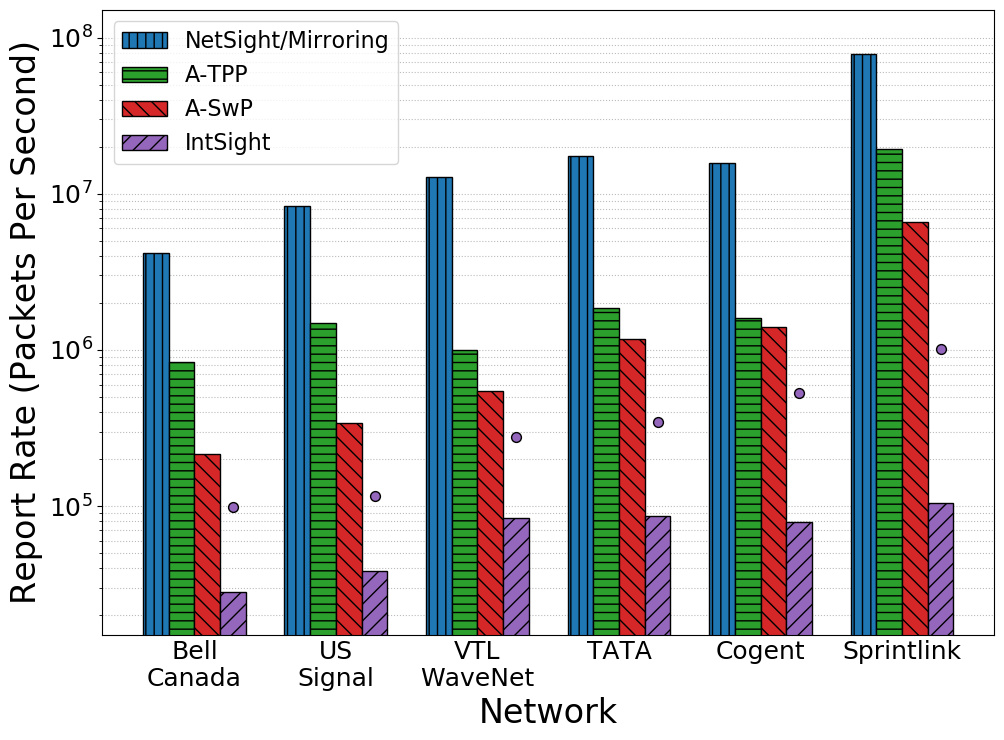

In [14]:
plots = [
    {
        'id': 'mirroring',
        'labels': ['NetSight/Mirroring'],
        'ys': ['report_rate'],
        'hatches': ['||'],
        'colors': ['tab:blue'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x,
    },
    {
        'id': 'tpp',
        'labels': ['A-TPP'],
        'ys': ['report_rate'],
        'hatches': ['--'],
        'colors': ['tab:green'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x,
    },
    {
        'id': 'switchpointer',
        'labels': ['A-SwP'],
        'ys': ['report_rate'],
        'hatches': ['\\\\'],
        'colors': ['#D62728'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x,
    },
    {
        'id': 'intsight',
        'labels': ['IntSight'],
        'ys': ['report_rate_avg'], 
        'hatches': ['//'],
        'colors': ['tab:purple'],
        'yerrs': None,
        'ymaxs': ['report_rate_max'],
        'yadjust': lambda x, y, z: x,
    },
]

fig, info = plot_bars(dfs, networks, plots, xlabel='Network', ylabel='Report Rate (Packets Per Second)', yscale='log', ylim=(1.5*10e3, 1.5*10e7))

# print(info)

pylab.savefig('./paper_results/fig7a.pdf')


## Figure 7(b) – Device memory usage (Mb).

# A-SwP (TCAM)
y: [0.29, 0.37, 0.65, 1.18, 1.61, 2.89]

# A-SwP (SRAM)
y: [30.42, 40.8, 112.85, 164.86, 224.39, 175.25]

# IntSight (TCAM)
y: [0.29, 0.37, 0.65, 1.18, 1.61, 2.89]

# IntSight (SRAM)
y: [12.78, 16.41, 26.84, 42.78, 58.23, 89.53]




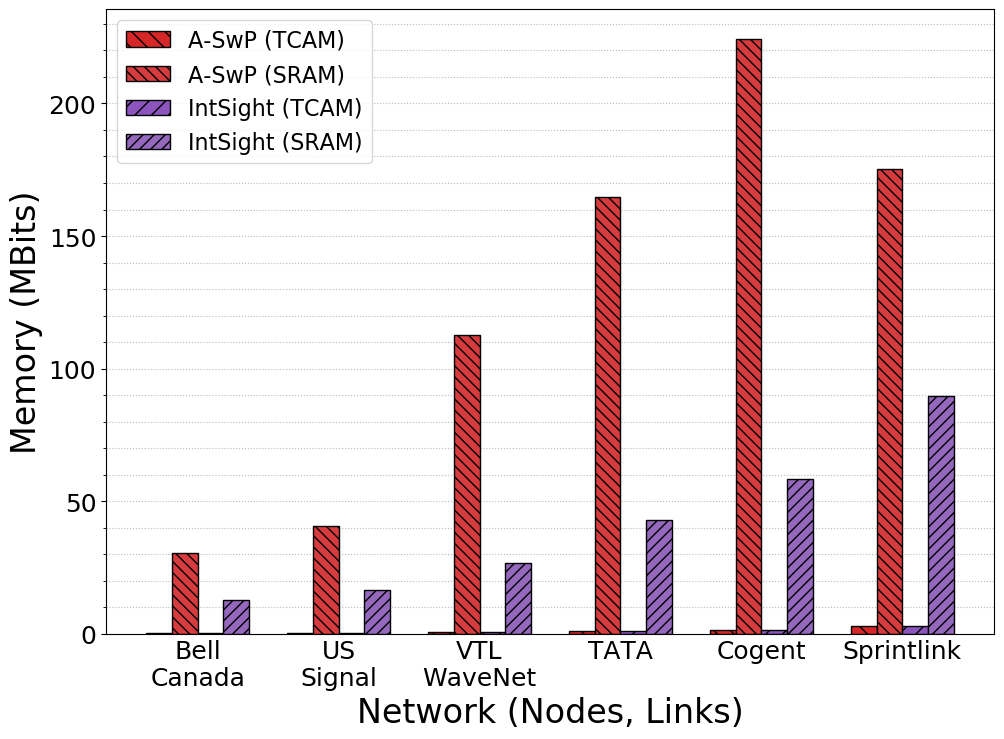

In [15]:
plots = [
    {
        'id': 'switchpointer',
        'labels': ['A-SwP (TCAM)', 'A-SwP (SRAM)'],
        'ys': ['tcam_all', 'sram_all'],
        'hatches': ['\\\\', '\\\\\\'],
        'colors': ['#D62728', '#D63C3E'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x/1e6,
    },
    {
        'id': 'intsight',
        'labels': ['IntSight (TCAM)', 'IntSight (SRAM)'],
        'ys': ['tcam_all', 'sram_all'],
        'hatches': ['//', '///'],  #, '////', '/////'],
        'colors': ['#8B55BD', '#9468BD'],  #, '#9D7BBD', '#A68EBD'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x/1e6,
    },
]

fig, info = plot_bars(dfs, networks, plots, xlabel='Network (Nodes, Links)', ylabel='Memory (MBits)', yscale=None, stack=False)

print(info)

# pylab.savefig('./paper_results/fig7b.pdf')

with open('./paper_results/fig7b.txt', 'w') as f:
    f.write(info)


## Figure 7(c) – Header space usage (bytes).

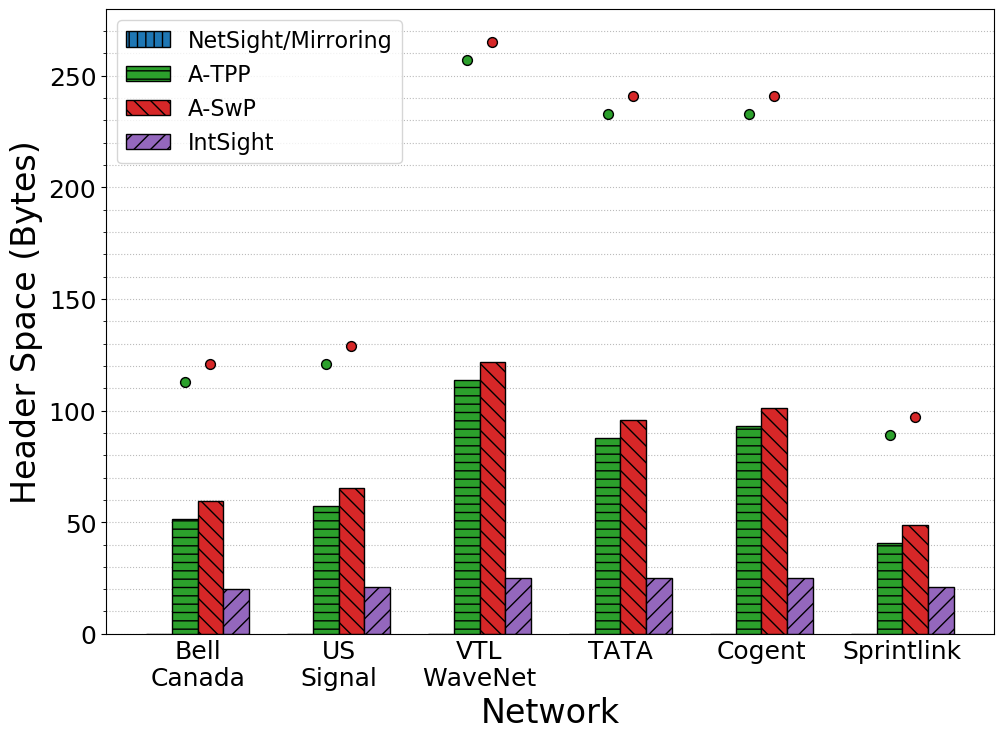

In [16]:
plots = [
    {
        'id': 'mirroring',
        'labels': ['NetSight/Mirroring'],
        'ys': ['header_space'],
        'hatches': ['||'],
        'colors': ['tab:blue'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x,
    },
    {
        'id': 'tpp',
        'labels': ['A-TPP'],
        'ys': ['header_space_avg'],
        'hatches': ['--'],
        'colors': ['tab:green'],
        'yerrs': None,
        'ymaxs': ['header_space_max'],
        'yadjust': lambda x, y, z: x,
    },
    {
        'id': 'switchpointer',
        'labels': ['A-SwP'],
        'ys': ['header_space_avg'],
        'hatches': ['\\\\'],
        'colors': ['#D62728'],
        'yerrs': None,
        'ymaxs': ['header_space_max'],
        'yadjust': lambda x, y, z: x,
    },
    {
        'id': 'intsight',
        'labels': ['IntSight'],
        'ys': ['header_space'], 
        'hatches': ['//'],
        'colors': ['tab:purple'],
        'yerrs': None,
        'ymaxs': None,
        'yadjust': lambda x, y, z: x,
    },
]

fig, info = plot_bars(dfs, networks, plots, xlabel='Network', ylabel='Header Space (Bytes)', stack=False)

# print(info)

pylab.savefig('./paper_results/fig7c.pdf')
